In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import math
import os

from parser.parse_csv import get_dt

In [2]:
figures_dir = "figures"
if not os.path.exists(figures_dir):
    os.makedirs(figures_dir)

In [3]:
# def latexify(fig_width=None, fig_height=None, columns=1):
#     """Set up matplotlib's RC params for LaTeX plotting.
#     Call this before plotting a figure.

#     Parameters
#     ----------
#     fig_width : float, optional, inches
#     fig_height : float,  optional, inches
#     columns : {1, 2}
#     """

#     # code adapted from http://www.scipy.org/Cookbook/Matplotlib/LaTeX_Examples

#     # Width and max height in inches for IEEE journals taken from
#     # computer.org/cms/Computer.org/Journal%20templates/transactions_art_guide.pdf

#     assert(columns in [1,2])

#     if fig_width is None:
#         fig_width = 3.39 if columns==1 else 6.9 # width in inches

#     if fig_height is None:
#         golden_mean = (math.sqrt(5)-1.0)/2.0    # Aesthetic ratio
#         fig_height = fig_width*golden_mean # height in inches
    
#     MAX_HEIGHT_INCHES = 8.0
#     if fig_height > MAX_HEIGHT_INCHES:
#         print("WARNING: fig_height too large:" + fig_height + 
#               "so will reduce to" + MAX_HEIGHT_INCHES + "inches.")
#         fig_height = MAX_HEIGHT_INCHES

#     params = {'backend': 'ps',
#               'text.latex.preamble': ["\\usepackage{libertine}"],
#               'axes.labelsize': 8, # fontsize for x and y labels (was 10)
#               'axes.titlesize': 8,
# #               'text.fontsize': 8, # was 10
#               'legend.fontsize': 8, # was 10
#               'xtick.labelsize': 8,
#               'ytick.labelsize': 8,
#               'text.usetex': True,
#               'figure.figsize': [fig_width, fig_height],
#               'font.family': 'serif',
#               'mathtext.default': 'regular'
#     }

#     matplotlib.rcParams.update(params)

# %matplotlib inline

# latexify(fig_width=2.1, fig_height=1.7)

In [4]:
mnist_valid_labels = pd.read_csv("parser/mnist_valid_labels.csv").set_index("SampleNumber")
mnist_test_labels = pd.read_csv("parser/mnist_test_labels.csv").set_index("SampleNumber")
fashion_mnist_valid_labels = pd.read_csv("parser/fashion_mnist_valid_labels.csv").set_index("SampleNumber")
fashion_mnist_test_labels = pd.read_csv("parser/fashion_mnist_test_labels.csv").set_index("SampleNumber")
cifar10_valid_labels = pd.read_csv("parser/cifar10_valid_labels.csv").set_index("SampleNumber")
cifar10_test_labels = pd.read_csv("parser/cifar10_test_labels.csv").set_index("SampleNumber")

In [5]:
def get_errors_valid(filename, dataset="mnist"):
    if dataset == "mnist":
        labels = mnist_valid_labels
    elif dataset == "fashion_mnist":
        labels = fashion_mnist_valid_labels
    else:
        labels = cifar10_valid_labels
    dt = get_dt(filename, labels)

    adv_results = dt.groupby("ProcessedSolveStatus")["SolveStatus"].count().to_dict()
#     print(adv_results)
    cumulative_adv_results = []
    accumulator = adv_results["ProvablyRobustByClass"]
    del adv_results["ProvablyRobustByClass"]
    adv_results_numbers = {}
    for k, v in adv_results.items():
        if k.startswith("InfeasibleDistance"):
            dist = float(k[18:])
        elif k.startswith("InfeasibleUndecidedDistance"):
            dist = float(k[27:])
        else:
            continue
        adv_results_numbers[dist] = adv_results_numbers.get(dist, 0) + v
    for i in range(-24, 41):
        if i / 10 in adv_results_numbers:
            accumulator += adv_results_numbers[i / 10]
        cumulative_adv_results.append(accumulator)
    # Exclude 4.0 distance
    cumulative_adv_results = cumulative_adv_results[:-1]

    if "StatusUnknown" in adv_results:
        accumulator += adv_results["StatusUnknown"]
    
    if accumulator != 5000:
        print("Only", accumulator, "samples verified so far")

    nat_results = [
        np.logical_and(
            dt["NaturalInputMinDistance"].values >= x / 10,
            (dt.PredictedIndex == dt.TrueIndex).values
        ).sum()
        for x in range(-24, 40) # Exclude 4.0 distance
    ]

    return (np.around(1 - np.asarray(nat_results) / accumulator, decimals=4),
            np.around(1 - np.asarray(cumulative_adv_results) / accumulator, decimals=4))

def get_errors_test(filename, threshold=None, dataset="mnist"):
    if dataset == "mnist":
        labels = mnist_test_labels
    elif dataset == "fashion_mnist":
        labels = fashion_mnist_test_labels
    else:
        labels = cifar10_test_labels
    dt = get_dt(filename, labels)

    if threshold is not None:
        nat_results = np.logical_and(dt["NaturalInputMinDistance"].values >= threshold,
                                     (dt.PredictedIndex == dt.TrueIndex).values).sum()
    else:
        nat_results = (dt.PredictedIndex == dt.TrueIndex).values.sum()

    adv_results = dt.groupby("ProcessedSolveStatus")["PredictedIndex"].count().to_dict()
    
    print(adv_results)
    
    if "InfeasibleDistance" in adv_results:
        adv_results["ProvablyRobustByClass"] += adv_results["InfeasibleDistance"]

    return (np.around(1 - nat_results / dt["PredictedIndex"].count(), decimals=4),
            np.around(1 - adv_results["ProvablyRobustByClass"] / dt["PredictedIndex"].count(), decimals=4))

def get_errors_test_human_experts(filename, threshold, dataset="mnist"):
    if dataset == "mnist":
        labels = mnist_test_labels
    elif dataset == "fashion_mnist":
        labels = fashion_mnist_test_labels
    else:
        labels = cifar10_test_labels
    dt = get_dt(filename, labels)

    nat_results = np.logical_or(
        dt["NaturalInputMinDistance"].values < threshold,
        (dt.PredictedIndex == dt.TrueIndex).values
    ).sum()

    adv_results = dt.groupby("ProcessedSolveStatus")["PredictedIndex"].count().to_dict()
    
    print(adv_results)

    if "InfeasibleDistance" in adv_results:
        adv_results["ProvablyRobustByClass"] += adv_results["InfeasibleDistance"]

    return (np.around(1 - nat_results / dt["PredictedIndex"].count(), decimals=4),
            np.around(1 - adv_results["ProvablyRobustByClass"] / dt["PredictedIndex"].count(), decimals=4),
            (dt["NaturalInputMinDistance"].values < threshold).sum() / dt["PredictedIndex"].count())

## Test results

In [6]:
for dataset in ["IBP_MNIST_SmallCNN_train_0.200_eval_0.100_elide/Apr29_22-00-04/weights_100_0.971__linf-norm-bounded-0.1__Inf__0.0",
                "IBP_MNIST_MediumCNN_train_0.200_eval_0.100_elide/Apr29_21-58-36/weights_100_0.973__linf-norm-bounded-0.1__Inf__0.0",
                "IBP_MNIST_SmallCNN_train_0.300_eval_0.200_elide/May01_09-41-57/weights_100_0.946__linf-norm-bounded-0.2__Inf__0.0",
                "IBP_MNIST_MediumCNN_train_0.300_eval_0.200_elide/May01_10-45-41/weights_100_0.953__linf-norm-bounded-0.2__Inf__0.0",
                "IBP_MNIST_SmallCNN_train_0.400_eval_0.300_elide/Apr29_22-01-57/weights_100_0.906__linf-norm-bounded-0.3__Inf__0.0",
                "IBP_MNIST_MediumCNN_train_0.400_eval_0.300_elide/Apr29_21-55-33/weights_100_0.915__linf-norm-bounded-0.3__Inf__0.0",
                "RS_MNIST_SmallCNN_eps_0.100/May04_00-42-45/weights_070_0.96__linf-norm-bounded-0.1__Inf__0.0",
                "RS_MNIST_SmallCNN_eps_0.200/May04_00-43-25/weights_070_0.95__linf-norm-bounded-0.2__Inf__0.0",
                "RS_MNIST_SmallCNN_eps_0.300/May06_09-53-34/weights_070_0.91__linf-norm-bounded-0.3__Inf__0.0"]:
    filename = "verification_results/test/" + dataset + "/summary.csv"
    print(dataset)
    print(get_errors_test(filename))
    print()

IBP_MNIST_SmallCNN_train_0.200_eval_0.100_elide/Apr29_22-00-04/weights_100_0.971__linf-norm-bounded-0.1__Inf__0.0
{'ProvablyRobustByClass': 9688, 'Vulnerable': 312}
(0.0157, 0.0312)

IBP_MNIST_MediumCNN_train_0.200_eval_0.100_elide/Apr29_21-58-36/weights_100_0.973__linf-norm-bounded-0.1__Inf__0.0
{'ProvablyRobustByClass': 9732, 'StatusUnknown': 1, 'Vulnerable': 267}
(0.0132, 0.0268)

IBP_MNIST_SmallCNN_train_0.300_eval_0.200_elide/May01_09-41-57/weights_100_0.946__linf-norm-bounded-0.2__Inf__0.0
{'ProvablyRobustByClass': 9389, 'Vulnerable': 611}
(0.0238, 0.0611)

IBP_MNIST_MediumCNN_train_0.300_eval_0.200_elide/May01_10-45-41/weights_100_0.953__linf-norm-bounded-0.2__Inf__0.0
{'ProvablyRobustByClass': 9524, 'StatusUnknown': 5, 'Vulnerable': 471}
(0.0186, 0.0476)

IBP_MNIST_SmallCNN_train_0.400_eval_0.300_elide/Apr29_22-01-57/weights_100_0.906__linf-norm-bounded-0.3__Inf__0.0
{'ProvablyRobustByClass': 8941, 'Vulnerable': 1059}
(0.0348, 0.1059)

IBP_MNIST_MediumCNN_train_0.400_eval_0.300

## MNIST 0.1

Minimise nat and adv error at delta =  0.4
Nat accuracy 0.0202
Adv accuracy 0.02 

Minimise nat and adv error at delta =  0.6
Nat accuracy 0.0164
Adv accuracy 0.0168 

Minimise nat and adv error at delta =  0.1
Nat accuracy 0.0126
Adv accuracy 0.0126 



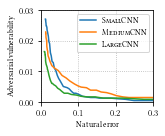

In [7]:
for dataset, label in zip(["IBP_MNIST_SmallCNN_train_0.200_eval_0.100_elide/Apr29_22-00-04/weights_100_0.971__linf-norm-bounded-0.1__Inf__0.0",
                           "IBP_MNIST_MediumCNN_train_0.200_eval_0.100_elide/Apr29_21-58-36/weights_100_0.973__linf-norm-bounded-0.1__Inf__0.0",
                           "IBP_MNIST_LargeCNN_train_0.200_eval_0.100_elide/Apr29_21-41-43/weights_100_0.980__linf-norm-bounded-0.1__Inf__0.0"],
                          ["\\textsc{SmallCNN}", "\\textsc{MediumCNN}", "\\textsc{LargeCNN}"]):

    filename = "verification_results/validation/" + dataset + "/summary.csv"
    nat_errors, adv_errors = get_errors_valid(filename)
    plt.plot(nat_errors, adv_errors, label=label)
    plt.xlabel("Natural error")
    plt.ylabel("Adversarial vulnerability")

    plt.grid(True, "both", linestyle="dotted")

    min_max = 1
    nat_err = 1
    adv_err = 1
    delta = 0
    for (a, b, c) in zip(nat_errors, adv_errors, range(-24, 41)):
        if max(a, b) < min_max:
            min_max = max(a, b)
            nat_err = a
            adv_err = b
            delta = c / 10

    print("Minimise nat and adv error at delta = ", delta)
    print("Nat accuracy", nat_err)
    print("Adv accuracy", adv_err, "\n")

plt.axis([0,0.3,0,0.03])
plt.legend()

plt.tight_layout(pad=0)
plt.savefig(os.path.join(figures_dir, "verification_validation_mnist_01.pdf"), pad_inches=0)

In [8]:
large_01_test = "verification_results/test_min_dist_0.1/IBP_MNIST_LargeCNN_train_0.200_eval_0.100_elide/Apr29_21-41-43/weights_100_0.980__linf-norm-bounded-0.1__Inf__0.0/summary.csv"
print(get_errors_test(large_01_test, 0.1))

{'InfeasibleDistance': 59, 'ProvablyRobustByClass': 9776, 'StatusUnknown': 4, 'Vulnerable': 161}
(0.0166, 0.0165)


## MNIST 0.2

Minimise nat and adv error at delta =  0.9
Nat accuracy 0.0328
Adv accuracy 0.032 

Minimise nat and adv error at delta =  1.0
Nat accuracy 0.0292
Adv accuracy 0.029 

Minimise nat and adv error at delta =  0.7
Nat accuracy 0.0254
Adv accuracy 0.0262 



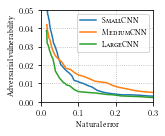

In [9]:
for dataset, label in zip(["IBP_MNIST_SmallCNN_train_0.300_eval_0.200_elide/May01_09-41-57/weights_100_0.946__linf-norm-bounded-0.2__Inf__0.0",
                           "IBP_MNIST_MediumCNN_train_0.300_eval_0.200_elide/May01_10-45-41/weights_100_0.953__linf-norm-bounded-0.2__Inf__0.0",
                           "IBP_MNIST_LargeCNN_train_0.300_eval_0.200_elide/May01_10-46-22/weights_100_0.956__linf-norm-bounded-0.2__Inf__0.0"],
                          ["\\textsc{SmallCNN}", "\\textsc{MediumCNN}", "\\textsc{LargeCNN}"]):

    filename = "verification_results/validation/" + dataset + "/summary.csv"
    nat_errors, adv_errors = get_errors_valid(filename)
    plt.plot(nat_errors, adv_errors, label=label)
    plt.xlabel("Natural error")
    plt.ylabel("Adversarial vulnerability")

    plt.grid(True, "both", linestyle="dotted")

    min_max = 1
    nat_err = 1
    adv_err = 1
    delta = 0
    for (a, b, c) in zip(nat_errors, adv_errors, range(-24, 41)):
        if max(a, b) < min_max:
            min_max = max(a, b)
            nat_err = a
            adv_err = b
            delta = c / 10

    print("Minimise nat and adv error at delta = ", delta)
    print("Nat accuracy", nat_err)
    print("Adv accuracy", adv_err, "\n")

plt.axis([0,0.3,0,0.05])
plt.legend()

plt.tight_layout(pad=0)
plt.savefig(os.path.join(figures_dir, "verification_validation_mnist_02.pdf"), pad_inches=0)

In [10]:
large_02_test = "verification_results/test_min_dist_0.7/IBP_MNIST_LargeCNN_train_0.300_eval_0.200_elide/May01_10-46-22/weights_100_0.956__linf-norm-bounded-0.2__Inf__0.0/summary.csv"
print(get_errors_test(large_02_test, 0.7))

{'InfeasibleDistance': 144, 'ProvablyRobustByClass': 9535, 'StatusUnknown': 66, 'Vulnerable': 255}
(0.0306, 0.0321)


## MNIST 0.3

Minimise nat and adv error at delta =  1.0
Nat accuracy 0.0552
Adv accuracy 0.0556 

Minimise nat and adv error at delta =  1.1
Nat accuracy 0.0508
Adv accuracy 0.0566 

Minimise nat and adv error at delta =  1.3
Nat accuracy 0.0438
Adv accuracy 0.043 



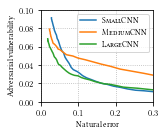

In [11]:
for dataset, label in zip(["IBP_MNIST_SmallCNN_train_0.400_eval_0.300_elide/Apr29_22-01-57/weights_100_0.906__linf-norm-bounded-0.3__Inf__0.0",
                           "IBP_MNIST_MediumCNN_train_0.400_eval_0.300_elide/Apr29_21-55-33/weights_100_0.915__linf-norm-bounded-0.3__Inf__0.0",
                           "IBP_MNIST_LargeCNN_train_0.400_eval_0.300_elide/Apr29_21-47-39/weights_100_0.926__linf-norm-bounded-0.3__Inf__0.0"],
                          ["\\textsc{SmallCNN}", "\\textsc{MediumCNN}", "\\textsc{LargeCNN}"]):

    filename = "verification_results/validation/" + dataset + "/summary.csv"
    nat_errors, adv_errors = get_errors_valid(filename)
    plt.plot(nat_errors, adv_errors, label=label)
    plt.xlabel("Natural error")
    plt.ylabel("Adversarial vulnerability")

    plt.grid(True, "both", linestyle="dotted")

    min_max = 1
    nat_err = 1
    adv_err = 1
    delta = 0
    for (a, b, c) in zip(nat_errors, adv_errors, range(-24, 41)):
        if max(a, b) < min_max:
            min_max = max(a, b)
            nat_err = a
            adv_err = b
            delta = c / 10

    print("Minimise nat and adv error at delta = ", delta)
    print("Nat accuracy", nat_err)
    print("Adv accuracy", adv_err, "\n")

plt.axis([0,0.3,0,0.1])
plt.legend()

plt.tight_layout(pad=0)
plt.savefig(os.path.join(figures_dir, "verification_validation_mnist_03.pdf"), pad_inches=0)

In [12]:
large_02_test = "verification_results/test_min_dist_1.3/IBP_MNIST_LargeCNN_train_0.400_eval_0.300_elide/Apr29_21-47-39/weights_100_0.926__linf-norm-bounded-0.3__Inf__0.0/summary.csv"
print(get_errors_test(large_02_test, 1.3))

{'InfeasibleDistance': 310, 'ProvablyRobustByClass': 9159, 'StatusUnknown': 169, 'Vulnerable': 362}
(0.0536, 0.0531)


## Use human experts

In [13]:
for dataset in ["IBP_MNIST_LargeCNN_train_0.200_eval_0.100_elide/Apr29_21-41-43/weights_100_0.980__linf-norm-bounded-0.1__Inf__0.0",
                "IBP_MNIST_LargeCNN_train_0.300_eval_0.200_elide/May01_10-46-22/weights_100_0.956__linf-norm-bounded-0.2__Inf__0.0",
                "IBP_MNIST_LargeCNN_train_0.400_eval_0.300_elide/Apr29_21-47-39/weights_100_0.926__linf-norm-bounded-0.3__Inf__0.0"]:
    filename = "verification_results/validation/" + dataset + "/summary.csv"
    dt = get_dt(filename, mnist_valid_labels)
    nat_results = [(dt["NaturalInputMinDistance"].values >= x / 10).sum()
                   for x in range(-24, 40)] # Exclude 4.0 distance
    nat_errors, adv_errors = get_errors_valid(filename)

    nat_results = [x for x in nat_results if x >= 4800]
    index = len(nat_results)
    print(index, (index - 24) / 10, nat_results[-1], adv_errors[index])

39 1.5 4815 0.0044
38 1.4 4820 0.0152
37 1.3 4801 0.043


## Withold 5%

In [14]:
for dataset, index in zip(["IBP_MNIST_LargeCNN_train_0.200_eval_0.100_elide/Apr29_21-41-43/weights_100_0.980__linf-norm-bounded-0.1__Inf__0.0",
                           "IBP_MNIST_LargeCNN_train_0.300_eval_0.200_elide/May01_10-46-22/weights_100_0.956__linf-norm-bounded-0.2__Inf__0.0",
                           "IBP_MNIST_LargeCNN_train_0.400_eval_0.300_elide/Apr29_21-47-39/weights_100_0.926__linf-norm-bounded-0.3__Inf__0.0"],
                          [39, 38, 37]):
    threshold = (index - 24) / 10
    filename = "verification_results/test_min_dist_" + str(threshold) + "/" + dataset + "/summary.csv"
    print(get_errors_test_human_experts(filename, threshold))

{'InfeasibleDistance': 167, 'ProvablyRobustByClass': 9776, 'StatusUnknown': 4, 'Vulnerable': 53}
(0.0019, 0.0057, 0.0458)
{'InfeasibleDistance': 246, 'ProvablyRobustByClass': 9535, 'StatusUnknown': 52, 'Vulnerable': 167}
(0.002, 0.0219, 0.0473)
{'InfeasibleDistance': 310, 'ProvablyRobustByClass': 9159, 'StatusUnknown': 169, 'Vulnerable': 362}
(0.0038, 0.0531, 0.0498)


## Withold 10%

In [15]:
for dataset, index in zip(["IBP_MNIST_LargeCNN_train_0.200_eval_0.100_elide/Apr29_21-41-43/weights_100_0.980__linf-norm-bounded-0.1__Inf__0.0",
                           "IBP_MNIST_LargeCNN_train_0.300_eval_0.200_elide/May01_10-46-22/weights_100_0.956__linf-norm-bounded-0.2__Inf__0.0",
                           "IBP_MNIST_LargeCNN_train_0.400_eval_0.300_elide/Apr29_21-47-39/weights_100_0.926__linf-norm-bounded-0.3__Inf__0.0"],
                          [45, 46, 46]):
    threshold = (index - 24) / 10
    filename = "verification_results/test_min_dist_" + str(threshold) + "/" + dataset + "/summary.csv"
    print(get_errors_test_human_experts(filename, threshold))

{'InfeasibleDistance': 197, 'ProvablyRobustByClass': 9776, 'StatusUnknown': 4, 'Vulnerable': 23}
(0.0007, 0.0027, 0.1033)
{'InfeasibleDistance': 345, 'ProvablyRobustByClass': 9535, 'StatusUnknown': 44, 'Vulnerable': 76}
(0.0009, 0.012, 0.0942)
{'InfeasibleDistance': 526, 'ProvablyRobustByClass': 9161, 'StatusUnknown': 98, 'Vulnerable': 215}
(0.0016, 0.0313, 0.1074)


## Withold 20%

In [16]:
for dataset, index in zip(["IBP_MNIST_LargeCNN_train_0.200_eval_0.100_elide/Apr29_21-41-43/weights_100_0.980__linf-norm-bounded-0.1__Inf__0.0",
                           "IBP_MNIST_LargeCNN_train_0.300_eval_0.200_elide/May01_10-46-22/weights_100_0.956__linf-norm-bounded-0.2__Inf__0.0",
                           "IBP_MNIST_LargeCNN_train_0.400_eval_0.300_elide/Apr29_21-47-39/weights_100_0.926__linf-norm-bounded-0.3__Inf__0.0"],
                          [49, 54, 53]):
    threshold = (index - 24) / 10
    filename = "verification_results/test_min_dist_" + str(threshold) + "/" + dataset + "/summary.csv"
    print(get_errors_test_human_experts(filename, threshold))

{'InfeasibleDistance': 208, 'ProvablyRobustByClass': 9776, 'StatusUnknown': 2, 'Vulnerable': 14}
(0.0002, 0.0016, 0.1887)
{'InfeasibleDistance': 412, 'ProvablyRobustByClass': 9535, 'StatusUnknown': 27, 'Vulnerable': 26}
(0.0002, 0.0053, 0.211)
{'InfeasibleDistance': 654, 'ProvablyRobustByClass': 9161, 'StatusUnknown': 60, 'Vulnerable': 125}
(0.0004, 0.0185, 0.1925)


## CIFAR-10 2/255

Minimise nat and adv error at delta =  0.3
Nat accuracy 0.4744
Adv accuracy 0.4516 



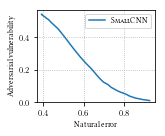

In [17]:
for dataset, label in zip(["IBP_CIFAR10_SmallCNN_train_0.009_eval_0.008_elide/May06_13-14-55/weights_350_0.434__linf-norm-bounded-0.007843137__Inf__0.0",
                           #"IBP_CIFAR10_LargeCNN_2_train_0.009_eval_0.008_elide/May11_10-53-11/weights_400_0.441__linf-norm-bounded-0.007843137__Inf__0.0"
                          ],
                          ["\\textsc{SmallCNN}", #"Large2"
                          ]):

    filename = "verification_results/validation/" + dataset + "/summary.csv"
    nat_errors, adv_errors = get_errors_valid(filename, dataset="cifar")
    plt.plot(nat_errors, adv_errors, label=label)
    plt.xlabel("Natural error")
    plt.ylabel("Adversarial vulnerability")

    plt.grid(True, "both", linestyle="dotted")

    min_max = 1
    nat_err = 1
    adv_err = 1
    delta = 0
    for (a, b, c) in zip(nat_errors, adv_errors, range(-24, 41)):
        if max(a, b) < min_max:
            min_max = max(a, b)
            nat_err = a
            adv_err = b
            delta = c / 10

    print("Minimise nat and adv error at delta = ", delta)
    print("Nat accuracy", nat_err)
    print("Adv accuracy", adv_err, "\n")

plt.axis([0.37,0.95,0,0.57])
plt.legend()

plt.tight_layout(pad=0)
plt.savefig(os.path.join(figures_dir, "verification_validation_cifar_2_255.pdf"), pad_inches=0)

In [18]:
small_02_test = "verification_results/test_min_dist_0.3/IBP_CIFAR10_SmallCNN_train_0.009_eval_0.008_elide/May06_13-14-55/weights_350_0.434__linf-norm-bounded-0.007843137__Inf__0.0/summary.csv"
print(get_errors_test(small_02_test, 0.3, dataset="cifar"))

{'InfeasibleDistance': 621, 'ProvablyRobustByClass': 4505, 'Vulnerable': 4874}
(0.486, 0.4874)


## CIFAR-10 8/255

Minimise nat and adv error at delta =  0.3
Nat accuracy 0.6518
Adv accuracy 0.6534 



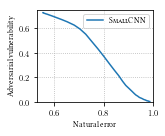

In [19]:
for dataset, label in zip(["IBP_CIFAR10_SmallCNN_train_0.035_eval_0.031_elide/May06_13-56-54/weights_350_0.265__linf-norm-bounded-0.031372549__Inf__0.0",
                           #"IBP_CIFAR10_LargeCNN_2_train_0.035_eval_0.031_elide/May10_21-26-24/weights_400_0.271__linf-norm-bounded-0.031372549__Inf__0.0"
                          ],
                          ["\\textsc{SmallCNN}", #"Large2"
                          ]):

    filename = "verification_results/validation/" + dataset + "/summary.csv"
    nat_errors, adv_errors = get_errors_valid(filename, dataset="cifar")
    plt.plot(nat_errors, adv_errors, label=label)
    plt.xlabel("Natural error")
    plt.ylabel("Adversarial vulnerability")

    plt.grid(True, "both", linestyle="dotted")

    min_max = 1
    nat_err = 1
    adv_err = 1
    delta = 0
    for (a, b, c) in zip(nat_errors, adv_errors, range(-24, 41)):
        if max(a, b) < min_max:
            min_max = max(a, b)
            nat_err = a
            adv_err = b
            delta = c / 10

    print("Minimise nat and adv error at delta = ", delta)
    print("Nat accuracy", nat_err)
    print("Adv accuracy", adv_err, "\n")

plt.axis([0.53,1,0,0.75])
plt.legend()

plt.tight_layout(pad=0)
plt.savefig(os.path.join(figures_dir, "verification_validation_cifar_8_255.pdf"), pad_inches=0)

In [20]:
small_08_test = "verification_results/test_min_dist_0.3/IBP_CIFAR10_SmallCNN_train_0.035_eval_0.031_elide/May06_13-56-54/weights_350_0.265__linf-norm-bounded-0.031372549__Inf__0.0/summary.csv"
print(get_errors_test(small_08_test, 0.3, dataset="cifar"))

{'InfeasibleDistance': 759, 'ProvablyRobustByClass': 2698, 'Vulnerable': 6543}
(0.6495, 0.6543)


## CIFAR-10 test results

In [21]:
for dataset in ["IBP_CIFAR10_SmallCNN_train_0.009_eval_0.008_elide/May06_13-14-55/weights_350_0.434__linf-norm-bounded-0.007843137__Inf__0.0",
                "IBP_CIFAR10_SmallCNN_train_0.035_eval_0.031_elide/May06_13-56-54/weights_350_0.265__linf-norm-bounded-0.031372549__Inf__0.0"]:
    filename = "verification_results/test/" + dataset + "/summary.csv"
    print(dataset)
    print(get_errors_test(filename, dataset="cifar"))
    print()

IBP_CIFAR10_SmallCNN_train_0.009_eval_0.008_elide/May06_13-14-55/weights_350_0.434__linf-norm-bounded-0.007843137__Inf__0.0
{'ProvablyRobustByClass': 4505, 'Vulnerable': 5495}
(0.4088, 0.5495)

IBP_CIFAR10_SmallCNN_train_0.035_eval_0.031_elide/May06_13-56-54/weights_350_0.265__linf-norm-bounded-0.031372549__Inf__0.0
{'ProvablyRobustByClass': 2698, 'Vulnerable': 7302}
(0.5461, 0.7302)



## CIFAR use human experts

In [22]:
for dataset in ["IBP_CIFAR10_SmallCNN_train_0.009_eval_0.008_elide/May06_13-14-55/weights_350_0.434__linf-norm-bounded-0.007843137__Inf__0.0",
                "IBP_CIFAR10_SmallCNN_train_0.035_eval_0.031_elide/May06_13-56-54/weights_350_0.265__linf-norm-bounded-0.031372549__Inf__0.0"]:
    filename = "verification_results/validation/" + dataset + "/summary.csv"
    dt = get_dt(filename, cifar10_valid_labels)
    nat_results = [(dt["NaturalInputMinDistance"].values >= x / 10).sum()
                   for x in range(-24, 40)] # Exclude 4.0 distance
    nat_errors, adv_errors = get_errors_valid(filename, dataset="cifar")

    nat_results = [x for x in nat_results if x >= 4200]
    index = len(nat_results)
    print(index, (index - 24) / 10, nat_results[-1], nat_errors[index], adv_errors[index])

26 0.2 4268 0.455 0.4746
24 0.0 4346 0.5916 0.7002


## Withold 5%

In [23]:
for dataset, index in zip(["IBP_CIFAR10_SmallCNN_train_0.009_eval_0.008_elide/May06_13-14-55/weights_350_0.434__linf-norm-bounded-0.007843137__Inf__0.0",
                           "IBP_CIFAR10_SmallCNN_train_0.035_eval_0.031_elide/May06_13-56-54/weights_350_0.265__linf-norm-bounded-0.031372549__Inf__0.0"],
                          [22,20]):
    threshold = (index - 24) / 10
    filename = "verification_results/test_min_dist_" + str(threshold) + "/" + dataset + "/summary.csv"
    print(get_errors_test_human_experts(filename, threshold, dataset="cifar"))

{'InfeasibleDistance': 140, 'ProvablyRobustByClass': 4505, 'Vulnerable': 5355}
(0.3683, 0.5355, 0.0556)
{'InfeasibleDistance': 51, 'ProvablyRobustByClass': 2698, 'Vulnerable': 7251}
(0.5122, 0.7251, 0.0435)


## Withold 10%

In [24]:
for dataset, index in zip(["IBP_CIFAR10_SmallCNN_train_0.009_eval_0.008_elide/May06_13-14-55/weights_350_0.434__linf-norm-bounded-0.007843137__Inf__0.0",
                           "IBP_CIFAR10_SmallCNN_train_0.035_eval_0.031_elide/May06_13-56-54/weights_350_0.265__linf-norm-bounded-0.031372549__Inf__0.0"],
                          [24,22]):
    threshold = (index - 24) / 10
    filename = "verification_results/test_min_dist_" + str(threshold) + "/" + dataset + "/summary.csv"
    print(get_errors_test_human_experts(filename, threshold, dataset="cifar"))

{'InfeasibleDistance': 310, 'ProvablyRobustByClass': 4505, 'Vulnerable': 5185}
(0.3288, 0.5185, 0.1122)
{'InfeasibleDistance': 138, 'ProvablyRobustByClass': 2698, 'Vulnerable': 7164}
(0.4763, 0.7164, 0.0914)


## Withold 20%

In [25]:
for dataset, index in zip(["IBP_CIFAR10_SmallCNN_train_0.009_eval_0.008_elide/May06_13-14-55/weights_350_0.434__linf-norm-bounded-0.007843137__Inf__0.0",
                           "IBP_CIFAR10_SmallCNN_train_0.035_eval_0.031_elide/May06_13-56-54/weights_350_0.265__linf-norm-bounded-0.031372549__Inf__0.0"],
                          [26,24]):
    threshold = (index - 24) / 10
    filename = "verification_results/test_min_dist_" + str(threshold) + "/" + dataset + "/summary.csv"
    print(get_errors_test_human_experts(filename, threshold, dataset="cifar"))

{'InfeasibleDistance': 621, 'ProvablyRobustByClass': 4505, 'Vulnerable': 4874}
(0.2759, 0.4874, 0.1916)
{'InfeasibleDistance': 269, 'ProvablyRobustByClass': 2698, 'Vulnerable': 7033}
(0.4167, 0.7033, 0.1745)


## Fashion MNIST

Minimise nat and adv error at delta =  0.5
Nat accuracy 0.2248
Adv accuracy 0.2214 

Minimise nat and adv error at delta =  0.7
Nat accuracy 0.2238
Adv accuracy 0.2184 

Minimise nat and adv error at delta =  0.4
Nat accuracy 0.2142
Adv accuracy 0.2174 



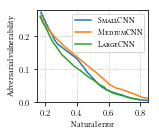

In [26]:
plt.figure()

fig = plt.gcf()
width, height = fig.get_size_inches()
fig.set_size_inches(width - 0.09, height)

for dataset, label in zip(["IBP_FASHION_MNIST_SmallCNN_train_0.125_eval_0.100_elide/May14_22-12-35/weights_200_0.725__linf-norm-bounded-0.1__Inf__0.0",
                           "IBP_FASHION_MNIST_MediumCNN_train_0.125_eval_0.100_elide/May14_23-38-31/weights_200_0.733__linf-norm-bounded-0.1__Inf__0.0",
                           "IBP_FASHION_MNIST_LargeCNN_train_0.125_eval_0.100_elide/May15_13-16-35/weights_200_0.736__linf-norm-bounded-0.1__Inf__0.0"],
                          ["\\textsc{SmallCNN}", "\\textsc{MediumCNN}", "\\textsc{LargeCNN}"]):

    filename = "verification_results/validation/" + dataset + "/summary.csv"
    nat_errors, adv_errors = get_errors_valid(filename, dataset="fashion_mnist")
    plt.plot(nat_errors, adv_errors, label=label)
    plt.xlabel("Natural error")
    plt.ylabel("Adversarial vulnerability")

    plt.grid(True, "both", linestyle="dotted")

    min_max = 1
    nat_err = 1
    adv_err = 1
    delta = 0
    for (a, b, c) in zip(nat_errors, adv_errors, range(-24, 41)):
        if max(a, b) < min_max:
            min_max = max(a, b)
            nat_err = a
            adv_err = b
            delta = c / 10

    print("Minimise nat and adv error at delta = ", delta)
    print("Nat accuracy", nat_err)
    print("Adv accuracy", adv_err, "\n")

plt.axis([0.15,.85,0,0.28])
plt.legend()

plt.tight_layout(pad=0)
plt.savefig(os.path.join(figures_dir, "verification_validation_fashion_mnist_01.pdf"), pad_inches=0)

## Use human experts

In [27]:
for dataset in ["IBP_FASHION_MNIST_LargeCNN_train_0.125_eval_0.100_elide/May15_13-16-35/weights_200_0.736__linf-norm-bounded-0.1__Inf__0.0"]:
    filename = "verification_results/validation/" + dataset + "/summary.csv"
    dt = get_dt(filename, fashion_mnist_valid_labels)
    nat_results = [(dt["NaturalInputMinDistance"].values >= x / 10).sum()
                   for x in range(-24, 40)] # Exclude 4.0 distance
    nat_errors, adv_errors = get_errors_valid(filename, dataset="fashion_mnist")

    nat_results = [x for x in nat_results if x >= 4800]
    index = len(nat_results)
    print(index, (index - 24) / 10, nat_results[-1], adv_errors[index])

23 -0.1 4810 0.246


In [ ]:
for dataset, index in zip(["IBP_FASHION_MNIST_LargeCNN_train_0.125_eval_0.100_elide/May15_13-16-35/weights_200_0.736__linf-norm-bounded-0.1__Inf__0.0"],
                          [23]):
    threshold = (index - 24) / 10
    filename = "verification_results/test_min_dist_" + str(threshold) + "/" + dataset + "/summary.csv"
    print(get_errors_test_human_experts(filename, threshold, dataset="fashion_mnist"))